# Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*.

## DC Motor model
We assume that we built the model of a DC electric motor that we want to validate. The motor is assumed to be connected to a constant load.
The dynamics of the actual DC motor that we want to capture are the connections between the *input* DC voltage and the motor speed and the DC current are considered as *outputs*.

<p align="center">
    <br>
  <img src="./DCMotor.svg" width="750" title="DCMotor" class="center">
</p>


### Validation setup
To validate our model we need to verify that its response is as close as possible to the actual DC motor response in front of the same *input* signal. Therefore, we need to log some **measurement data** and use them to stimulate our model, thus generating some **simulation data**. Both measurements and simulation data serve as inputs to Dymoval.

In this tutorial, we assume that we get some measurements logs from the labs where a team run some experiments and collected the results in a `HDF5` file and that another team developed a DC motor model. Although the latter team could also simulate the model by feeding it with the log data and provide us with just the simulation results, in this example we assume that they just provide a model but we need to simulate it by ourselves.


## Log data analysis
The first step is to extract the logs from the `HDF5` file and build a *dymoval* Dataset object but before doing that let's start by importing some useful packages:

In [1]:
# %matplotlib widget # requires ipympl package
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from itertools import product
import dymoval as dmv
import matplotlib

>**Note:**
>If your notebook supports interactive plots, then you may uncomment the first line of the above code cell. 

Let's read the log data stored in the `hdf5` file. All the logs that we are interested in are stored in the group "*signals*".
Feel free to explore the hdf5 file at your convenience.
We use the h5py package to read it, but feel free to explore any other package that can read HDF5 files.

In [2]:
logs = h5py.File('./DCMotorLogs.h5', 'r')
logs["signals"].keys()

<KeysViewHDF5 ['V', 'dot_theta', 'ia', 'theta']>

We can extract the logged signals as it follows (see *h5py* docs for more info)

In [3]:
V = logs["signals/V"]
ia = logs["signals/ia"]
dot_theta = logs["signals/dot_theta"]

At this point we cast the logs into *dymoval* `Signals`. 
Dymoval's `Signals` are utility Python `dict` (in reality they are `Typeddict`) used to represent signals. 

In [4]:
signal_list = []
for val in [V,ia, dot_theta]:
    temp:dmv.Signal={
        "name" : val.attrs["name"].decode('utf-8'),
        "samples" : val[:],
        "signal_unit" : val.attrs["unit"].decode('utf-8'),
        "sampling_period" : val.attrs["period"][0],
        "time_unit" : val.attrs["sampling_unit"].decode('utf-8'),
    }
    signal_list.append(deepcopy(temp))


Let's see how they look like

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:3054: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


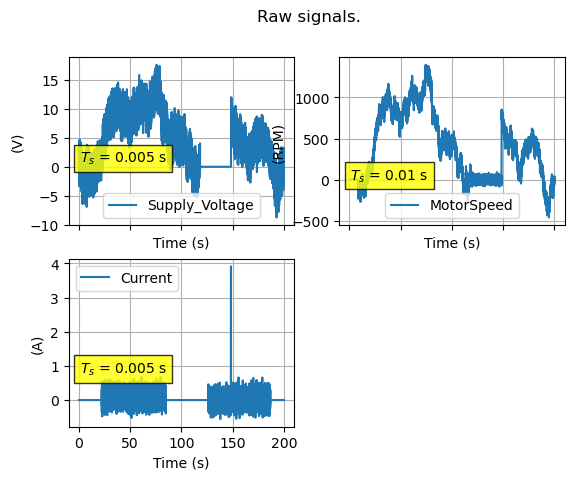

In [5]:
_= dmv.plot_signals(*signal_list)

As we can see, the signals have not been logged with the same sampling period and there is also some data logging interruption.
Well, things happen in the lab!

Nevertheless, a sound dataset shall have all the signals sampled with the same sampling period and it should not contains missing data. 
However, we can trim the signals in the time range e.g. $T = [30,80]\,s$ which seems a portion where no signal is missing data.

Finally, we can separate input and output signals and we can attempt to re-sample all of them with target sampling period equal to $0.01\,s$

In [6]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]
ds = dmv.Dataset(
    "DCMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin = 40,
    tout = 75.0
)

When creating a *Dataset* object, the signals are always re-sampled in such a way that all of them will have the same sampling period, but sometimes this is not possible and therefore some signals may be excluded from the Dataset. 

The list of the excluded signals are stored in the attibute `excluded_signal`.

In [7]:
ds.excluded_signals

[]

In this example all the signals have been correctly re-sampled and therefore there are no excluded signals.

Let's now take a look at how our Dataset looks like based on our selection. 

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


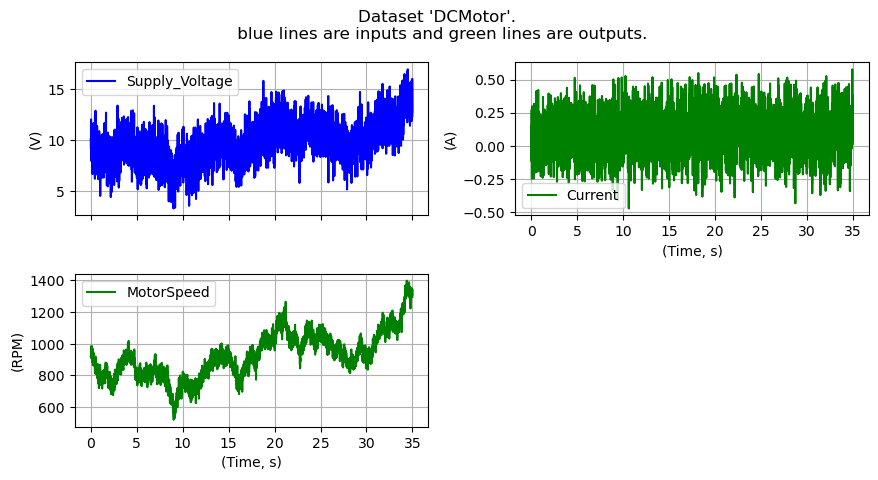

In [8]:
_= ds.plot()

...and let's check its coverage.

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1758: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


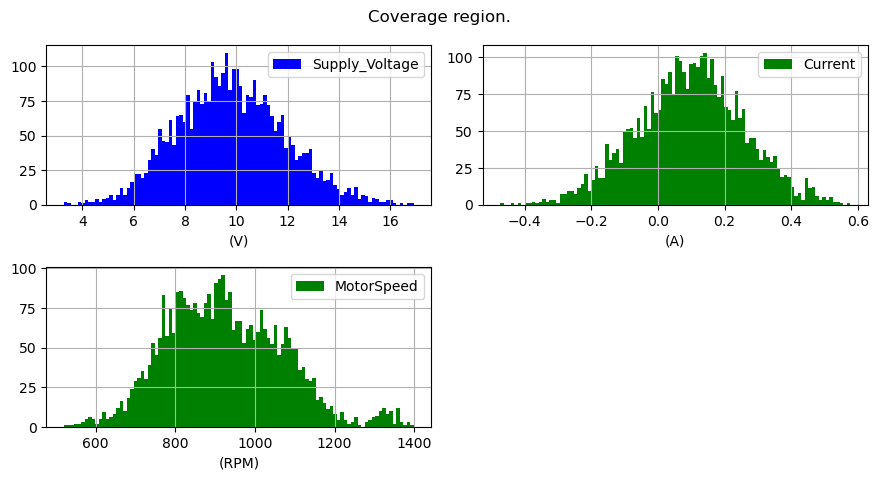

In [9]:
_= ds.plot_coverage()

The measurements are a bit noisy, so clean them up a little bit through a low pass filter.

To find the a good cutoff frequency, we perform a spectral analysis.
We first remove the continuous component through the `remove_means()` method, and then we plot the spectrum through the method `plot_spectrum()`

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:2265: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


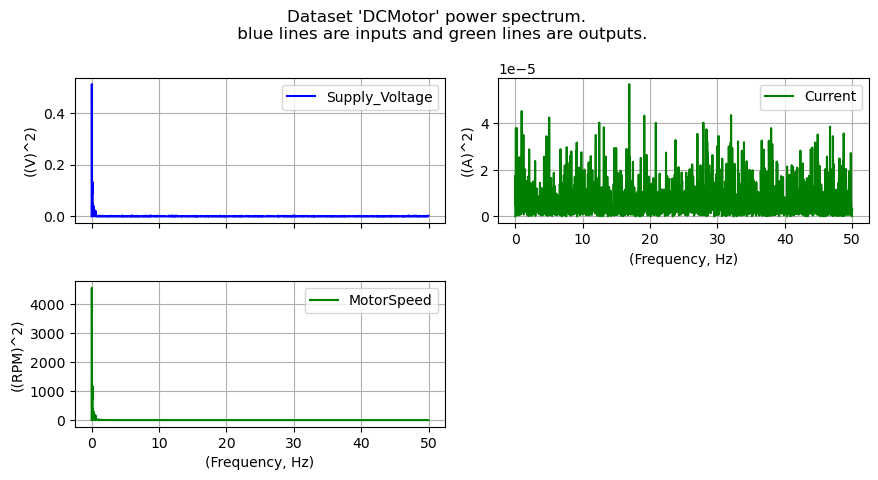

In [10]:
_= ds.remove_means().plot_spectrum()


The signals bandwidth of two over three signals is in contained very a narrow range $f < 1\, Hz$ with the exception of the "current" signal. We can low-filter the "Supply_Voltage" and the "MotorSpeed" signals whereas we keep the "Current" signal as is.

To don't penalize too much fast changes in the signal we stay a bit larger than $1\, Hz$. We choose a cutoff frequency $f_c = 5\, Hz$.

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


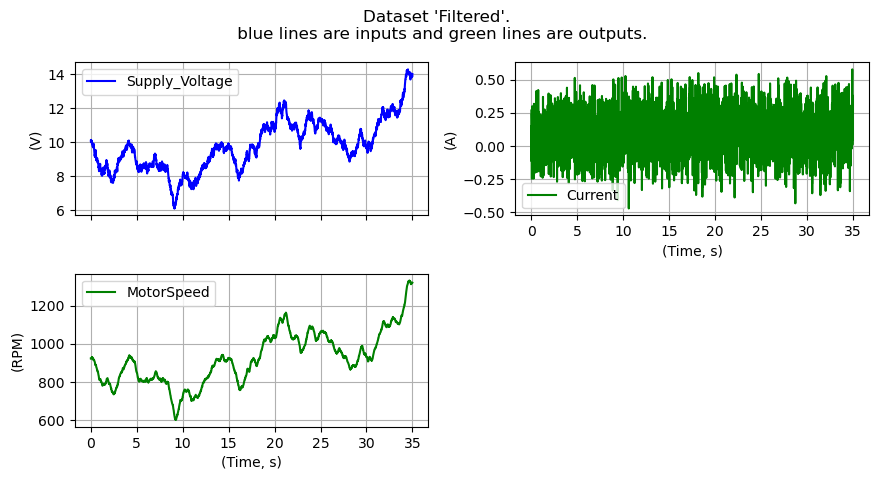

In [11]:
cutoff = 5  # [Hz]
ds_filt = ds.low_pass_filter((ds.signal_list()[0][1], cutoff),(ds.signal_list()[2][1], cutoff))
ds_filt.name = "Filtered"
_= ds_filt.plot()

Let's compare our datasets before and after the filtering. 

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


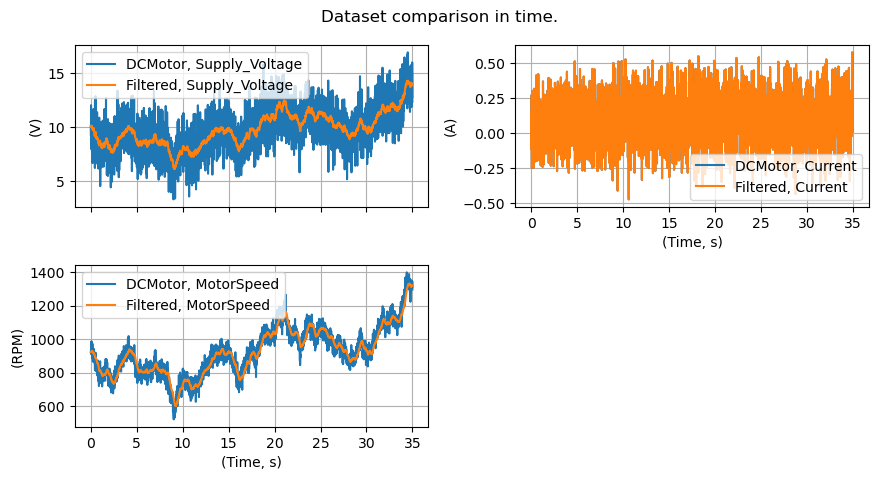

In [12]:
_= dmv.compare_datasets(ds,ds_filt)

The chosen cutoff frequency seems to clear most of the noise and it does not seem to intoduce too much lag.

Let's take a look how the coverage is affected.

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1758: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


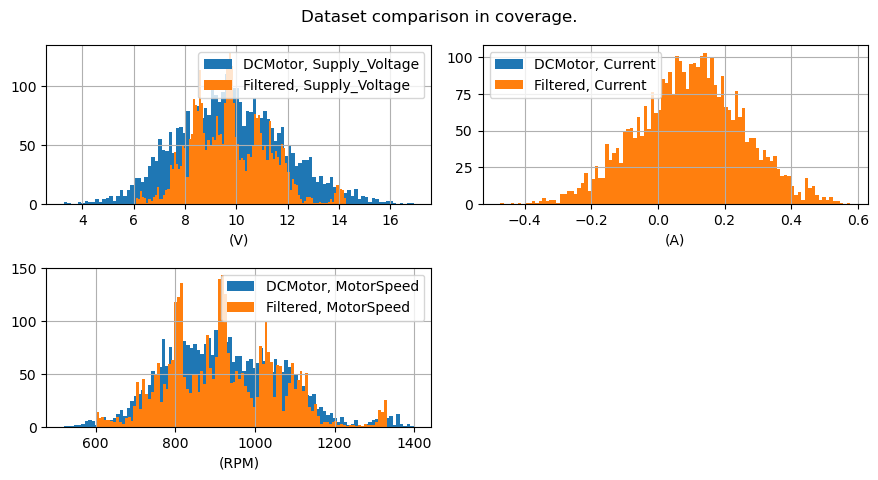

In [13]:
_= dmv.compare_datasets(ds,ds_filt, kind="coverage")

The coverage is pretty much the same, which means that we managed to remove noise without affecting the coverage region.
Let's also see the coverage statistics in terms of mean value and covariance matrices:

In [14]:
mean_in, cov_in, mean_out, cov_out = ds.coverage
mean_out

names       units
Current     A          0.096838
MotorSpeed  RPM      924.675152
dtype: float64

In [15]:
cov_out

,names,Current,MotorSpeed
,units,A,RPM
names,units,,
Current,A,0.025607,1.839447
MotorSpeed,RPM,1.839447,21552.617083


Only for the sake of showing more Dymoval features, we can selectively choose the signals that we want to plot or we can overlap them if we pass them as a tuple:

/Users/ubaldot/Documents/dymoval/src/dymoval/dataset.py:1608: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


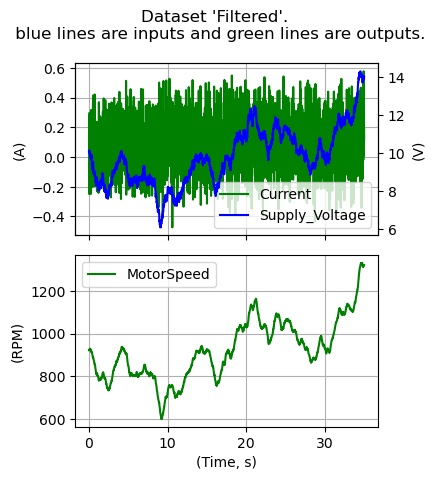

In [16]:
_= ds_filt.plot(("Current", "Supply_Voltage"),"MotorSpeed")

## Validation Session

Now that we have a "cleaned-up" *Dataset* object, we can validate our model.

First, we need to create a *ValidationSession* object from out Dataset object. We use the low-pass filtered one. All the simulations will be evaluated against such a dataset.

In [17]:
vs = dmv.ValidationSession("DCMotor_val", ds_filt)
#vs = dmv.ValidationSession("DCMotor_val", ds_filt, acorr_local_weights_1st = np.ones(100),acorr_local_weights_2nd = np.ones(100))

We now simulate our model with the input stored in `ds_filt` which is the input voltage.

To do that, we extract the numerical values of the input signal from the `Dataset` object

In [18]:
(t,u,y) = vs.dataset.dataset_values()

Then, we load our model and we feed it with the extracted input `u` and then we store the model response to a variable `y_sim`

>Note that it is not required to run any model within Python, nor it is required the model to have a specific model format. You just need to import the  simulation results of your model (that you may have simulated elsewhere) and append such simulation results to a  *dymoval* ValidationSession object. However, we also simulate the model in this example.

Let's import our model and let's simulate it:

In [19]:
from  DCMotorModel import DCMotor_dt
import control as ct

# Simulate model
res = ct.forced_response(DCMotor_dt, X0=[0.0, 0.0, 0.0], U = u)
y_sim = res.y.T[:,[0,2]]

Next, we append the simulation results `y_sim` to the *ValidationSession* object `vs`. 
The validation results are automatically computed. 

To append simulation results, we need to give a label to identify a simulation run and we shall also give a name to its output signals. 

In [51]:
measured_signals = ds_filt.dump_to_signals()
measured_in = signals['INPUT']
measured_out = signals['OUTPUT']
outcome, vs, _ = dmv.validation.validate_models(measured_in=measured_in,measured_out=measured_out,simulated_out=[y_sim], sampling_period=0.1, ignore_input=True)
print(outcome)
N = measured_in[0]['samples'].size
print(2.56**2/N)
vs

['PASS']
0.0018719223079120251


Validation session name: quick & dirty

Validation setup:
----------------
Input
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Validation results:
-------------------
                                         Sim_0
Input whiteness (mean-max)            0.609961
Input whiteness (quadratic-max)       0.406092
R-Squared (%)                        92.297743
Residuals whiteness (mean-max)        0.021257
Residuals whiteness (quadratic-max)   0.010734
Input-Res whiteness (mean-max)        0.064713
Input-Res whiteness (quadratic-max)   0.012684

/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1360: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1361: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


(<Figure size 444.5x305 with 1 Axes>,
 <Figure size 889x485 with 4 Axes>,
 <Figure size 889x305 with 2 Axes>)

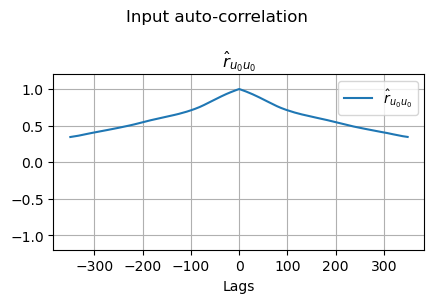

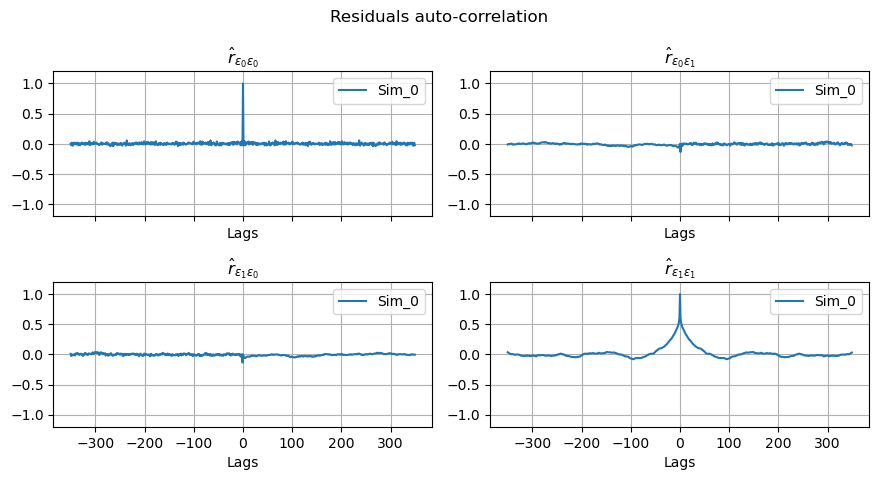

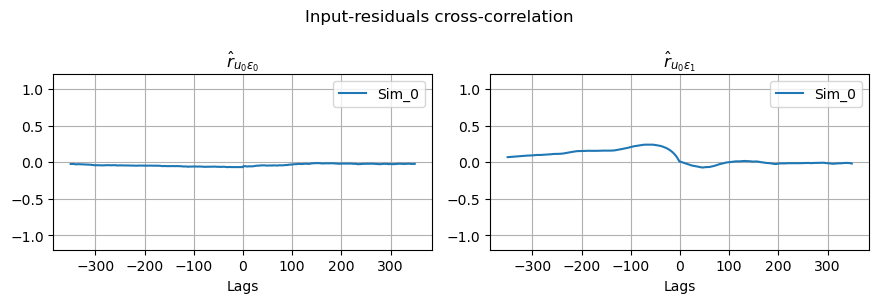

In [21]:
vs.plot_residuals()


In [22]:
# Append simulation
vs = vs.clear()
sim_name = "DCMotor_ss_model"
sim_labels = ["ia", "dot_theta"]
vs = vs.append_simulation(sim_name, sim_labels, y_sim)

Let's now compare the output of our model with the Dataset

/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1048: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


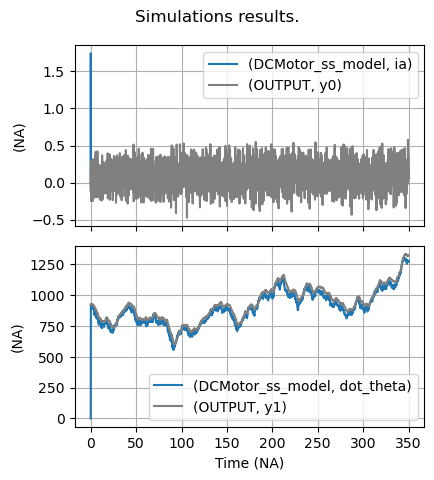

In [23]:
_=vs.plot_simulations(dataset='out')

With the exception of the initial peak exhibited by our model (we will explain later why such a peak), the graphical look of our system response looks promising. 

Let's take a look at the residuals plots.

/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1360: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1361: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


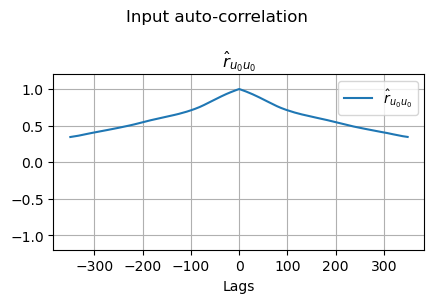

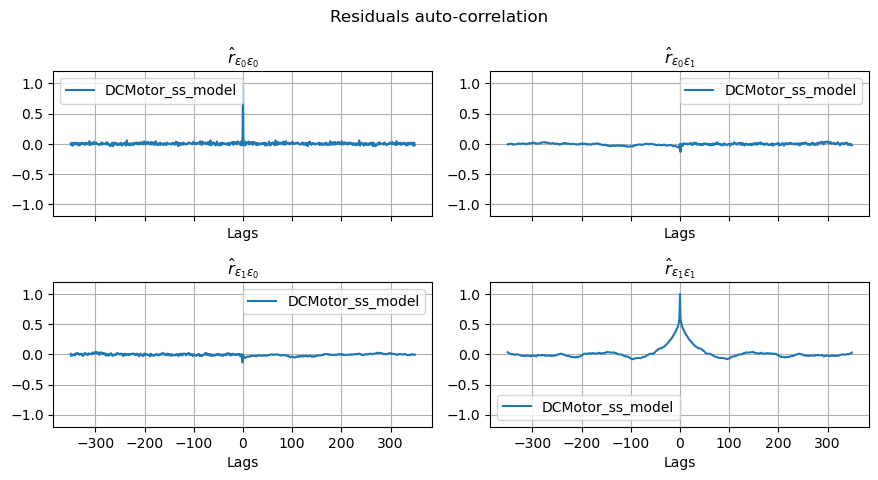

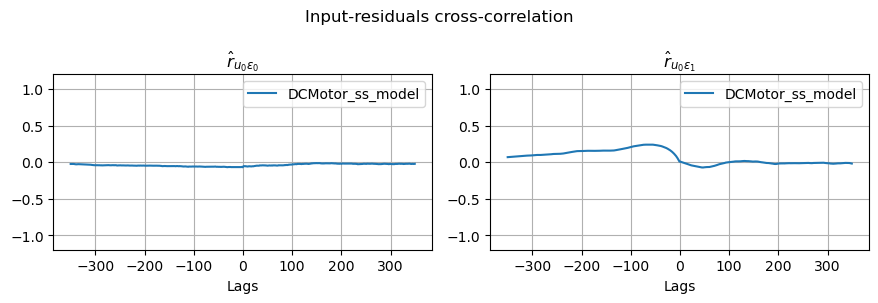

In [24]:
_ = vs.plot_residuals()

The residual plots look great! 
Let's also take a look at the validation metrics, which are just an attribute of the *ValidationSession* class:

The r-square fit looks very good as well as the residuals values. 

However, there is a subtle thing to notice. 
The considered dataset only includes the logged steady-state value of the real system (we trim the dataset around 30s, the motor was already in steady state at that time), whereas we simulated the model starting from a certain initial condition (= 0). Hence, around t = 0 we are comparing real system steady-state with model transient and that explains the mismatch in the time-plot of the simulations results versus the measurement data around t = 0. 

To overcome this issue, we can trim the validation dataset, thus excluding the portion around t = 0. In this way we compare real system steady-state VS model steady-state: 

/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1048: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Validation session name: quick & dirty

Validation setup:
----------------
Input
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 700

Validation results:
-------------------
                                     DCMotor_ss_model
Input whiteness (mean-max)                   0.609961
Input whiteness (quadratic-max)              0.406092
R-Squared (%)                               93.590209
Residuals whiteness (mean-max)               0.037087
Residuals whiteness (quadratic-max)          0.030588
Input-Res whiteness (mean-max)               0.087906
Input-Res whiteness (quadratic-max)          0.020897

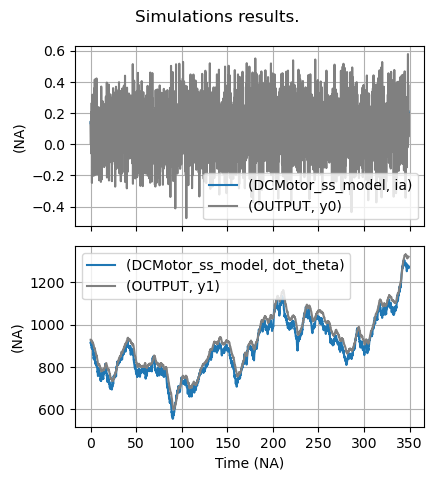

In [25]:
# trim the validation dataset between 1 and 35 seconds
vs = vs.trim(1,350)
vs.plot_simulations(dataset="out")
vs
#print(vs.auto_correlation['DCMotor_ss_model'])

As expected, the r2 squared slightly increased and the residuals didn't get affected too much, as we can seen fro the next plot. 

/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1359: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1360: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/Users/ubaldot/Documents/dymoval/src/dymoval/validation.py:1361: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


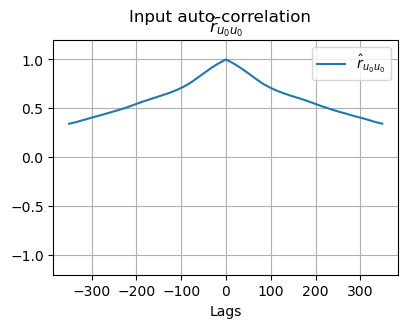

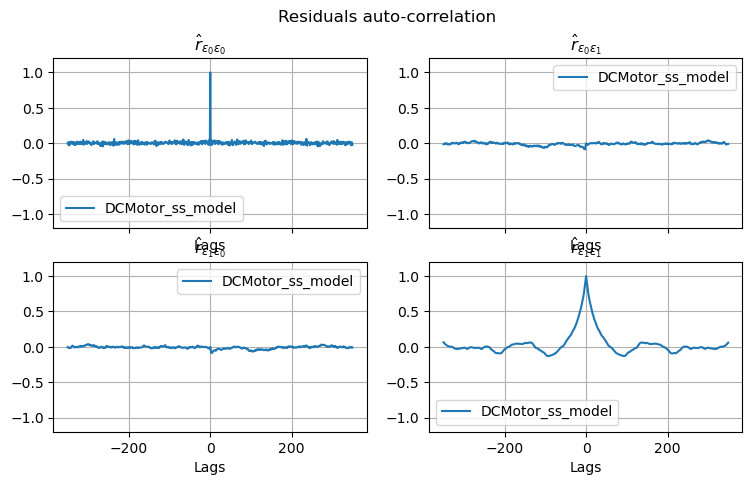

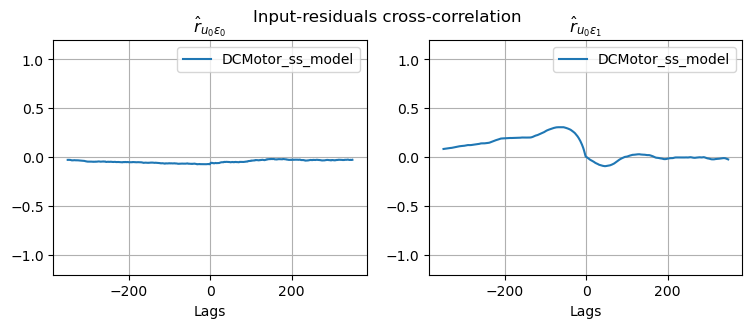

In [26]:
_ = vs.plot_residuals(layout="none")

We finished our validation exercise. 
Our model looks great! The fit in terms or r-squared looks excellent and the residuals norms are also excellent. However, you should not forget that your model **is reliable only on its validation region**. If you plan to use it outside the validation region, you shall consider logging measurements in such a region and re-validate your model against the new measurement dataset.

##  Summary: how to interpret the results? 

High values of r-squared do not say no much about your model (but low values do send you a clear message!), but you should always check the residuals as well.
The tractation of why you should check your residuals goes beyond this tutorial but there are lot of very good explanations in the web or, even better, on some System Identification book. 

Nevertheless, you can consider the following rule of thumbs: you want the r-squared index as high as possible and the residuals auto-correlation as close as possible to 1 and the input-residuals cross-correlation as small as possible. If that happens, then your model is good to go in its coverage region. 

Note that the default way the residuals auto-correlation and input-residuals cross-correlation are computed consider the *l-infinity norm* for each scalar signal with respect to the number of lags. The result after such an operation is a *p x q* matrix and the "2-norm" is computed on such a matrix. 
You may consider to change both the norms or to further manipulate them: for example you can normalize the l-norm if you replace the *l-infinity norm* with the *l-2 norm* or divide by *p x q* the result of the Matrix norm. 




#### Congrats! You arrived at the end of the tutorial! 

However, there are few things to remember.

#### Note 1
Dymoval is build to simplify common tasks that an engineer has to carry out and who may find tools such as pandas, matplotlib, numpy, etc. a bit too overwhelming.
However, if you need more power, consider that

1. Every plot returns a *matplotlib* figure, which means that you can further manipulate such a figure through the *matplotlib* API.
2. If you need to do further manipulate youd dataset and *dymoval* won't provide you certain functionalities, the you can use the method `dump_to_signals()` to dump the all the signals stored in the `Dataset` instance into a list of `Signals`. At this point you could use any packages you want (e.g. *numpy*, *scipy*, etc.) to manipulate the signals and then you may want to instantiate a brand new `Dataset` object from the manipulated signals.  


#### Note 2
When manipulating `Dataset` or `ValidationSession` object, Dymoval won't change the current instance, but it returns a modified copy of it.
This means that e.g. `ds.remove_means()` won't change `ds` but you should explicitely re-assign it, e.g. `ds = ds.remove_means()`.


#### Note 3
The main objects of *dymoval* are 

1. Signals, 
2. Datasets and 
3. ValidationSessions.

`Signals` are used as entry point from the external world to *dymoval*. We tried to keep them be as generic as possible.
`Datasets` are built upon *pandas* `DataFrames`. In-fact, the attribute `Dataset.dataset` is a pandas `DataFrame`:

In [27]:
ds_filt.dataset

kind               INPUT    OUTPUT             
names     Supply_Voltage   Current   MotorSpeed
units                  V         A          RPM
(Time, s)                                      
0.00           10.077867  0.147363   922.167737
0.01           10.077867 -0.116412   922.167737
0.02           10.031553  0.091202   922.253381
0.03           10.130776  0.272839   923.078013
0.04           10.107757  0.134555   923.357745
...                  ...       ...          ...
34.96          13.864479  0.379988  1319.621467
34.97          13.923826  0.047050  1319.925594
34.98          13.861071  0.149557  1319.104184
34.99          13.967038  0.118370  1319.105404
35.00          14.017112  0.190820  1320.363241

[3501 rows x 3 columns]

This means that in principle, you could use all the pandas `DataFrame` methods in dymoval.
However, although this can be useful in many casest, directly changing the values of a `Dataset.dataset` `DataFrame` is discouraged since a dymoval `Dataset` object has additional attributes such as coverage regions, *NaN* intervals, excluded signals and so on, that depends on the `dataset` attribute itself. Therefore, you may use the `dump_to_signals()` method as described in the **Note 1**, manipulate your signals and then create a new `Dataset` object.


In the same way, a *pandas* DataFrame is a `Dataset` object, then a `Dataset` object is an attribute of a `ValidationSession`:

In [28]:
type(vs.Dataset)

AttributeError: 'ValidationSession' object has no attribute 'Dataset'

This means that you can access all the methods and attributes of the stored `Dataset` object directly from a `ValidationSession` object.

But, again, it is discouraged to make any change directly to the `Dataset` object stored in a `ValidationSession` object. 
If you need a `ValidationSession` object with a different `Dataset`, just create a new one. 

## What's next?

Feel free to check the [documentation](https://volvogroup.github.io/dymoval/) to have access to the full API and to get more insight on how *dymoval* is structured.

Good luck!

# Credits
Picture from Mika Baumeister on Unsplash.